# Generate Timeline from profiling trace from nvvp

by Leiming Yu

* Twitter: @yu_leiming
* Blog: http://www1.coe.neu.edu/~ylm/

### prerequisite

profile your application using nvprof

```bash
nvprof --print-gpu-trace --csv Application_XXX 2> trace.csv 
```

In [253]:
import pandas as pd
import numpy as np
import operator

### read trace file

In [254]:
trace_file = "trace.csv"

# There are max 17 columns in the output csv
col_name = ["Start","Duration","Grid X","Grid Y","Grid Z","Block X","Block Y","Block Z","Registers Per Thread","Static SMem","Dynamic SMem","Size","Throughput","Device","Context","Stream","Name"]

df_trace = pd.read_csv(trace_file, names=col_name, engine='python')

rows_to_skip = 0

## find out the number of rows to skip
for index, row in df_trace.iterrows():
    if row['Start'] == 'Start':
        rows_to_skip = index
        break
        
# read the input csv again 
df_trace = pd.read_csv(trace_file, skiprows=rows_to_skip)

In [255]:
class transfer():
    def __init__(self, start=0.0,end=0.0):
        self.start_time_ms = start
        self.end_time_ms = end

In [256]:
class streams():
    def __init__(self):
        self.h2d = []
        self.d2h = []
        self.kernel = []

In [257]:
def time_coef_ms(df_trace):
    rows, cols = df_trace.shape
    
    start_unit = df_trace['Start'].iloc[0]
    duration_unit = df_trace['Duration'].iloc[0]
    
    start_coef =  1.0
    if start_unit == 's':
        start_coef = 1e3
    if start_unit == 'us':
        start_coef = 1e-3
    
    duration_coef =  1.0
    if duration_unit == 's':
        duration_coef = 1e3
    if duration_unit == 'us':
        duration_coef = 1e-3
        
    return start_coef, duration_coef

In [258]:
# read data for the current row
def read_row(df_row, start_coef_ms, duration_coef_ms):
    start_time_ms = float(df_row['Start']) * start_coef_ms
    
    end_time_ms = start_time_ms + float(df_row['Duration']) * duration_coef_ms
    
    stream_id = int(df_row['Stream'])
    
    api_name = df_row['Name'].to_string()
    
    if "DtoH" in api_name:
        api_type = 'd2h'
    elif "HtoD" in api_name:
        api_type = 'h2d'
    else:
        api_type = 'kernel'
    
    return stream_id, api_type, start_time_ms, end_time_ms

### extract data from the trace

In [259]:
streamList = []

# read the number of unique streams
stream_id_list = df_trace['Stream'].unique()
stream_id_list = stream_id_list[~np.isnan(stream_id_list)] # remove nan
# stream_id_list = list(stream_id_list)
num_streams = len(stream_id_list)

for i in xrange(num_streams):
    streamList.append(streams())

In [260]:
start_coef, duration_coef = time_coef_ms(df_trace)

# read row by row
for rowID in xrange(1, df_trace.shape[0]):
    #  extract info from the current row
    stream_id, api_type, start_time_ms, end_time_ms = read_row(df_trace.iloc[[rowID]], start_coef, duration_coef)

    # find out index of the stream 
    sid, = np.where(stream_id_list==stream_id)

    # add the start/end time for different api calls
    if api_type == 'h2d':
        streamList[sid].h2d.append(transfer(start_time_ms, end_time_ms))
    elif api_type == 'd2h':
        streamList[sid].d2h.append(transfer(start_time_ms, end_time_ms))
    elif api_type == 'kernel':
        streamList[sid].kernel.append(transfer(start_time_ms, end_time_ms))
    else:
        print "Unknown. Error."

/home/leiming/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/leiming/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/leiming/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


### generate timeline

You may need to adjust the font size for the annotation. The default is 10.

In [261]:
import matplotlib.pyplot as plt
import numpy as np

In [262]:
fig, ax = plt.subplots()

# each bar will be 1 in height, the interval between centers of each bar is 2
# for example, bar 1 is at 1 with width 1 (1, 1), then bar 2 is at 3 with width 1 (3, 1), so on and so forth

transfer_color = '#C5EDEE'
kernel_color = '#D2E307'

stream_num = len(streamList)

ylim_max = 1 + stream_num * 2.0

stream_tag_pos =  []
stream_tag = []

for i in xrange(stream_num):
    ii = i + 1
    
    bar_center = ylim_max - ii * 2.0
    bar_loc = (bar_center, 1)  # width 1
    
    # y lable 
    stream_tag_pos.append(bar_center + 0.5) # 0.5 interv
    stream_tag.append('stream-'+ str(i))
    
    current_stream = streamList[i]
    
    api_call_seq = []
    api_color_seq = []
    
    # h2d
    for j in xrange(len(current_stream.h2d)):
        start_time = current_stream.h2d[j].start_time_ms
        duration = current_stream.h2d[j].end_time_ms - current_stream.h2d[j].start_time_ms # add start and duration
        api_call_seq.append((start_time, duration))
        
        api_color_seq.append(transfer_color) # add the color for bar
        
        # pos for the annotation: shift left 0.0015 in the middle of the bar
        ax.annotate('h2d', (start_time + duration * 0.35, bar_center + 0.25), fontsize=10)
        
        
    # d2h
    for j in xrange(len(current_stream.d2h)):
        start_time = current_stream.d2h[j].start_time_ms
        duration = current_stream.d2h[j].end_time_ms - current_stream.d2h[j].start_time_ms
        api_call_seq.append((start_time, duration))
        
        api_color_seq.append(transfer_color)
        
        # pos for the annotation: shift left 0.0015 in the middle of the bar
        ax.annotate('d2h', (start_time + duration * 0.35, bar_center + 0.25), fontsize=10)
        
    # kernel
    for j in xrange(len(current_stream.kernel)):
        start_time = current_stream.kernel[j].start_time_ms
        duration = current_stream.kernel[j].end_time_ms - current_stream.kernel[j].start_time_ms
        api_call_seq.append((start_time, duration))
        
        api_color_seq.append(kernel_color)
        
        # offset 0.0007 for kernel annotation
        ax.annotate('K', (start_time + duration * 0.35, bar_center + 0.25), fontsize=10)
        
    # add the bar to the plot for current stream
    ax.broken_barh(api_call_seq,
               bar_loc, 
               facecolors=api_color_seq)

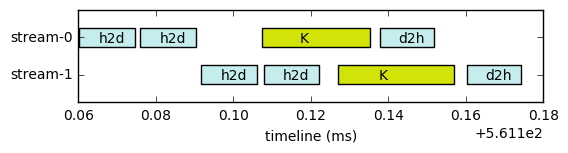

In [263]:
ax.set_ylim(0, ylim_max)

ax.set_xlabel('timeline (ms)')

ax.set_yticks(stream_tag_pos)
ax.set_yticklabels(stream_tag)


aspectratio=0.2
ratio_default=(ax.get_xlim()[1]-ax.get_xlim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0])
ax.set_aspect(ratio_default*aspectratio)

plt.show()

In [264]:
#fig.savefig('stream_timeline.pdf')